## 0. Постановка задачи
Имеем датасет, содержащий скоринговую информацию. Используя логистическую регрессию, строим на этом датасете предсказательную модель.

Описания полей
* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

Поскольку эксперимент заключался в проверке миксов различных подходов, данный ноутбук не воспроизводит этот крайне нелинейный процесс, а иллюстрирует его основные участки и использованные инструменты.



In [452]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

%matplotlib inline

## 1.  Загрузка и EDA

In [453]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

Первое, что видим: пропуски в колонке ***education***, причем, и в обучающей и в тестовой (!) выборке. В принципе, речь идет менее чем о полпроценте данных, поэтому проще всего было бы удалить. Но поскольку нам предстоит сдавать сабмит с фиксированным количеством строк, об удалении речи быть не может. Поэтому пропуски надо будет заполнить. Забегая вперед, заглушка "не предоставлено" не подходит, поскольку этот признак по своей сути ранговый. Заполним, поэтому, наиболее частым значением - SCH.

In [454]:
# cтавим флаги принадлежности к обучающей выборке
train['train'] = 1
test['train'] = 0
test['default'] = 0  # просто, чтобы не отсвечивали NaN в тестовой части датасета
# объединяем выборки в один датасет, чтобы обработка признаков происходила одновременно
data = pd.concat([train, test], sort = False)
# заполняем пропуски в образовании заглушкой
data.education.fillna('SCH', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 0 to 36348
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         110148 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        110

Дату подачи заявки мы сразу вынесем за рамки, как и id клиента - это внутренняя идентификация заявки, но не релеватная для обучения информация.

### Бинарные признаки
Посмотрим, какие у нас бинарные признаки

In [455]:

bin_cols = [x for x in data.columns if data[x].dropna().nunique() == 2][:-2] #последние два отбросим сразу это default и train
bin_cols

['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

Теоретически, признаки ***car*** и ***car_type*** можно было бы заменить одним ранговым, представляющим собой их сумму. Тогда ноль означал бы отсутствие машины, единица - отечественную, двойка - иномарку. Посмотрим, как такой признак связан с дефолтом. Для простоты, обойдемся пока без преобразований в 0/1 - в данном случае результат будет наглядным и так.
    

In [456]:
train['car_cat'] = train.car + train.car_type
# процент неплательщиков в каждой группе
train.groupby(by='car_cat').default.sum() / train.car_cat.value_counts()

NN    0.136960
YN    0.132744
YY    0.087450
dtype: float64

Получаем, что принципиальное отличие от основной массы дает владение иномаркой. А безлошадные и владельцы отечественного автопрома (точнее, его продукции) практически идентичны. Что дает нам основания в дальнейшем обойтись одним признаком car_type вместо двух или их производного.

In [457]:
for col in ['sex', 'good_work', 'foreign_passport']:
    display(train.groupby(by=col).default.sum() / train[col].value_counts())

sex
F    0.121241
M    0.134411
dtype: float64

good_work
0    0.133409
1    0.094502
dtype: float64

foreign_passport
N    0.136324
Y    0.074101
dtype: float64

Ожидаемо, практически не влияет пол, а признаки благополучия - хорошая работа и загранпаспорт очень даже влияют.
Пока что мы оставим все три признака и вместе с иномаркой преобразуем их в бинарный код.


In [458]:
bin_cols = ['car_type', 'sex', 'good_work', 'foreign_passport']

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

### Категориальные признаки

Начнем с образования. Расшифровки по типам образования у нас нет, но она легко угадывается: SCH - school, школьное, UGR - undergraduate, GRD - graduate магистр,  бакалавр, PGR - postgraduate, аспирант, ACD - academy, академия. Частота уровней образования почти обратно пропорциональна собственно уровню (для компактности гистограмма не приведена). Почти, потому что магистры опережают бакалвров. Очевидно, потому что тратить время/деньги на не очень полноценное высшее мало кто хочет. 

In [459]:
train.groupby(by='education').default.sum() / train.education.value_counts()


ACD    0.041237
GRD    0.090092
PGR    0.064439
SCH    0.150592
UGR    0.131520
dtype: float64

Как видим, доля должников обратно пропорциональна уровню образования. Признак будем кодировать в ранговый.

In [460]:
enc = LabelEncoder()
enc.fit(['SCH', 'UGR', 'GRD', 'PGR', 'ACD'])

data.education = enc.transform(data.education)

Связь заемщика с клиентами банка - параметр с неочевидным смыслом. Речь может идти либо о каких-то градациях взаимосвязи (например: член семьи, родственник, знакомый, никто)  либо просто об условной кодировке. 

In [461]:
train.groupby(by='sna').default.sum() / train.sna.value_counts()


1    0.098201
2    0.149821
3    0.157652
4    0.211507
dtype: float64

Но, в любом случае это ранговый параметр, коррелирующий с частотой дефолтов. То же можно сказать про параметр давности информации (только в этом случае корреляция отрицательная) и ***work_address***

In [462]:
train.groupby(by='first_time').default.sum() / train.first_time.value_counts()


1    0.186126
2    0.155429
3    0.120269
4    0.082030
dtype: float64

In [463]:
train.groupby(by='work_address').default.sum() / train.work_address.value_counts()

1    0.074154
2    0.102507
3    0.147957
dtype: float64

In [464]:
display(train.groupby(by='home_address').default.sum() / train.home_address.value_counts())

1    0.092896
2    0.155146
3    0.116057
dtype: float64

In [465]:
cat_cols = ['education', 'work_address', 'sna', 'first_time']


А вот в случае ***home_address*** уже нет такой наглядной корреляции. Этот параметр имеет смысл преобразовать OHE, переведя тем самым в бинарные признаки.

In [466]:
data = pd.get_dummies(data, columns=['home_address'], drop_first=True)
bin_cols += ['home_address_2', 'home_address_3']


### Числовые признаки 

По сравнению с бейслайном добавилось два новых числовых признака - рейтинг заемщиков в БКИ и рейтинг регионов, где они проживают. Рейтинг БКИ уже заранее нормирован по какому-то принципу. Также боксплот показывает, что должники несколько смещены относительно остальных заемщиков, но не зная принципов нормировки, сложно оценить масштаб.


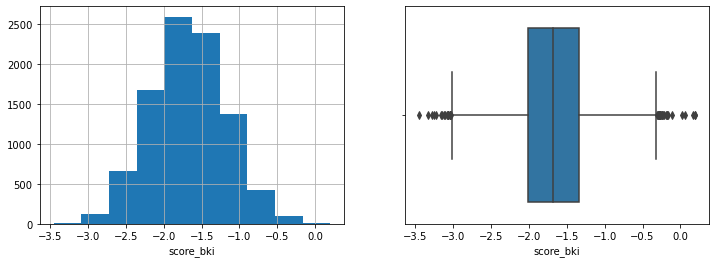

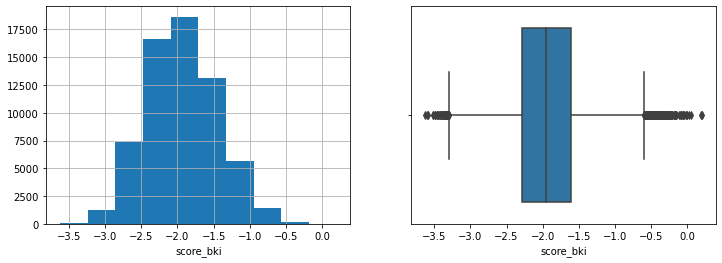

In [467]:
def hist_and_box (df_column):
    
    """ Для удобства вывод гистограммы и боксплота по одному параметру в ряд
    
        На входе колонка (не название, а сам объект pd.Series)"""
    
    bins= min([10, df_column.nunique()])
    
    fig = plt.figure(figsize=(12, 4)) 
    ax_1 = fig.add_subplot(121)
    ax_1.set_xlabel(df_column.name)
    df_column.hist(bins=bins, ax=ax_1)
    sns.boxplot(df_column, ax=fig.add_subplot(122))
    plt.show()
    return None

hist_and_box(train.query('default == 1').score_bki)
hist_and_box(train.query('default == 0').score_bki)


Рейтинг регионов с его семью возможными значениями можно трактовать и как категориальный, и как числовой параметр. (И в первом варианте, возможно, применить ОНЕ). Но, как показала проверка вариантов (за кадром), тот или иной подход не дал явных отличий в результате. Поэтому оставим его в числовых параметрах.

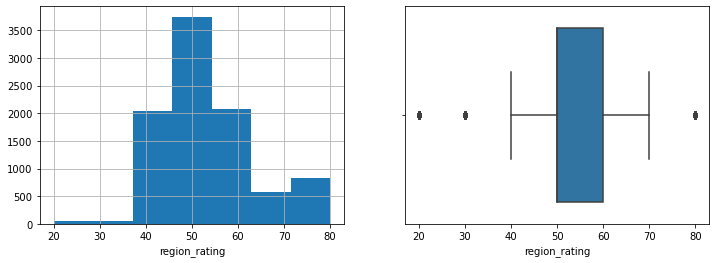

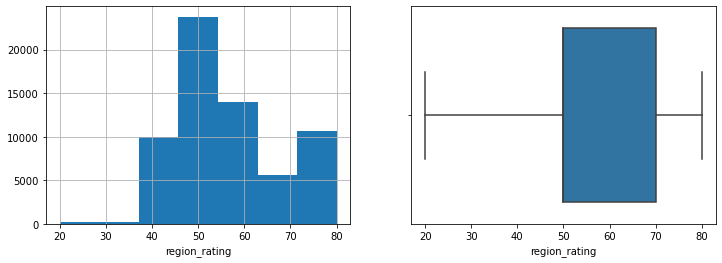

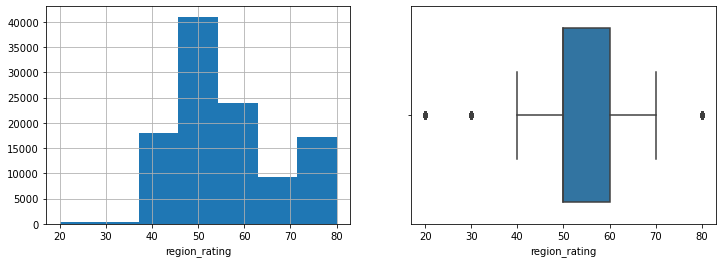

In [468]:
hist_and_box(train.query('default == 1').region_rating)
hist_and_box(train.query('default == 0').region_rating)
hist_and_box(data.region_rating)

Еще в бейслайне было обнаружено, что часть числовых признаков сильно смещена влево, и их следует логарифмировать, чтобы убрать это смещение. Новые (относительно бейслайна) числовые признаки распределены вполне симметрично, поэтому их добавляем, как есть.

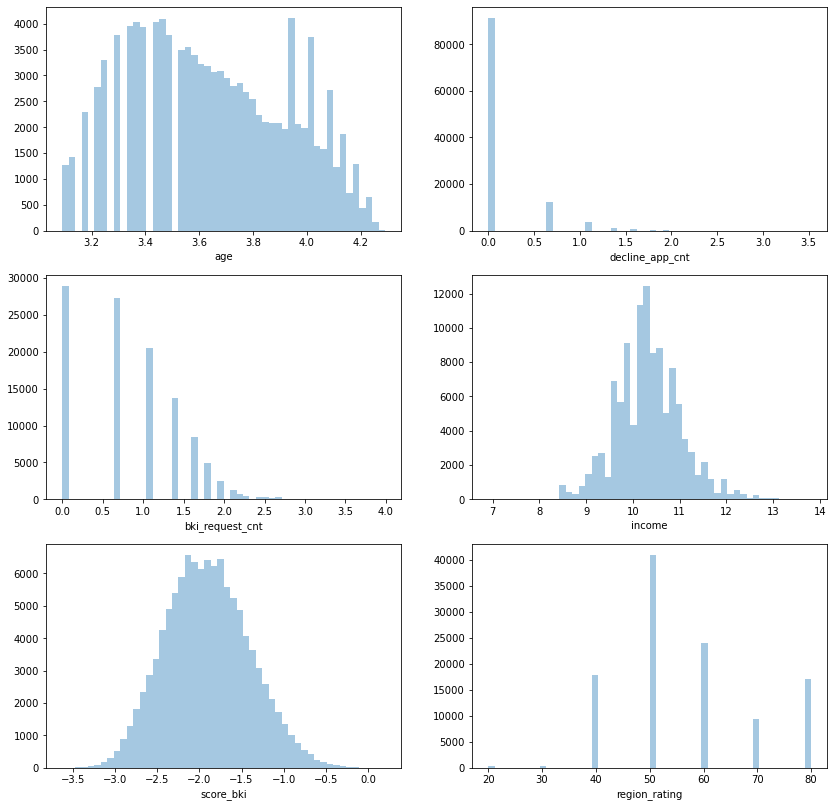

In [469]:
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
data[num_cols] = data[num_cols].apply(lambda x: np.log(x+1))
num_cols +=['score_bki', 'region_rating']
fig = plt.figure(figsize=(14,14) )
for j, column in enumerate(num_cols):
    
    ax=fig.add_subplot(3,2,j+1)
    sns.distplot(data[column].dropna(), kde = False, rug=False,ax=ax)
    
plt.show()

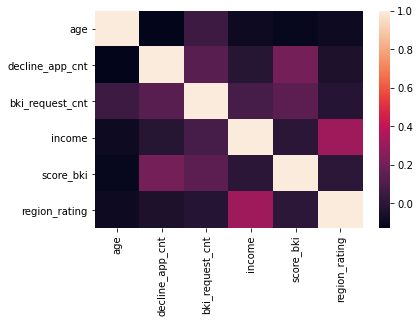

In [470]:
sns.heatmap(data[num_cols].corr())

Корреляция между числовыми параметрами в целом слабая.  На общем фоне чуть заметнее связь между доходом и рейтингом региона, а также между рейтингом БКИ и количеством отказов, но они все равно в "едва теплой" зоне. Отмасштабируем числовые переменные и посмотрим на ранг значимости на будущее.

In [471]:
scaler = StandardScaler()
scaler.fit(data[num_cols])
data[num_cols] = scaler.transform(data[num_cols])

In [472]:
#сначала, конечно, распочкуем данные назад на обучающую и тестовую выборки
train = data[data.train == 1]
test =  data[data.train == 0]

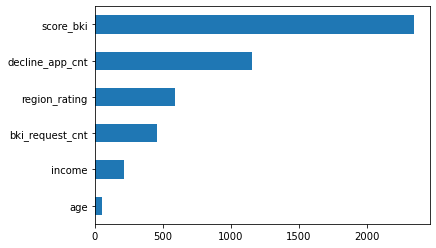

In [473]:
imp_num = Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

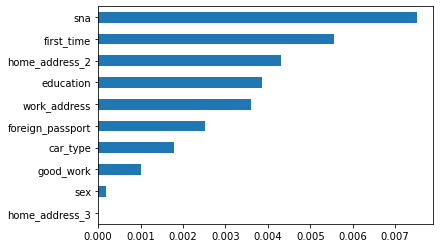

In [474]:
imp_cat = Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')


## 2 Обучение и валидация

Прежде всего, обратим внимание, что данные у нас выражено несбалансированные

In [475]:
train.default.value_counts(normalize=True)

0    0.873006
1    0.126994
Name: default, dtype: float64

Без учета этого фактора, итоговая метрика на лидерборде едва превышала 0.5 (а при ближайшем рассмотрении был сильный перекос в отрицательные, т.е. нулевые, значения). При этом, даже при кросс-валидации, дисбаланс никак не проявлял себя в явном виде. С познавательной точки зрения, были опробованы три способа балансировки: встроенный в библиотечную логистическую регрессию, апсэмплинг и даунсэмплинг.

In [476]:
from sklearn.utils import shuffle
def upsample (df, target_class):
    
    balance = df[target_class].value_counts()
    lesser = balance.idxmin()
    larger = balance.idxmax()
    rate = round(balance.max()/balance.min()) - 1
    
    new_df = pd.concat([df[df[target_class] == larger]] + [df[df[target_class] == lesser]]*rate)
    
    return shuffle(new_df)


def downsample (df, target_class):
    
    balance = df[target_class].value_counts()
    lesser = balance.idxmin()
    larger = balance.idxmax()
    rate = balance.min()/balance.max()
    
    new_df = pd.concat([df[df[target_class] == larger].sample(frac=rate), df[df[target_class] == lesser]])
    
    return shuffle(new_df)

In [477]:
train_up = upsample(train,'default')
train_dn = downsample(train,'default')

Довольно ожидаемо (основная проверка была на кэггле, поэтому нет смысла раздувать код), библиотечная балансировка показала себя наиболее эффективной, хотя по факту различия были в пределах плюс-минус одной пяти-десяти тысячных в метрике (если считать от средего показателя).


In [478]:
X = train[cat_cols+bin_cols+num_cols]
Y = train.default


In [479]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']
class_weight =[None, 'balanced']
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty, class_weight=class_weight)

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
print('Лучший баланс:', best_model.best_estimator_.get_params()['class_weight'])

Лучшее Penalty: l2
Лучшее C: 21.544346900318832
Лучший баланс: None


Любопытно, что оценка оптимальной регуляризации настойчиво предлагала несбалансированный вариант. 
Что касается кросс-валидации, разброс метрик она показывала на всех вариациах примерно один и тот же, и средняя метрика отличалась только в треьем знаке.

In [480]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression(solver='liblinear', C=7.74, class_weight='balanced') 
model = lm.fit(X_train, y_train)
from sklearn.model_selection import cross_val_score
cross_val_score(lm, X, Y, cv=10, scoring='roc_auc')

array([0.73715412, 0.72822028, 0.72348818, 0.72723022, 0.73257302,
       0.72819989, 0.73309297, 0.74731079, 0.71299523, 0.72035803])

In [481]:
%%time
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

sfs = SFS(model, 
          k_features=(7,16), 
          forward=False, 
          floating=False, 
          scoring='roc_auc',
          cv=2)
sfs = sfs.fit(X, Y)

print('Best  score: %.2f' % sfs.k_score_)

print('Best subset (corresponding names):',  sfs.k_feature_names_)

Best  score: 0.73
Best subset (corresponding names): ('education', 'work_address', 'sna', 'first_time', 'car_type', 'sex', 'good_work', 'foreign_passport', 'home_address_2', 'age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating')
Wall time: 25.9 s


Также были опробованы различные способы отбора признаков, начиная с интуитивных вручную и заканчивая SequentialFeatureSelector (выше) и ExhaustiveFeatureSelector (в силу высокой ресурсоемкости запускался отдельно и не включен в ноутбук). Существенного сокращения количества признаков ни один из методов не предложил. В принципе, все отличия укладывались в основном в плюс минус пять тысячных от 0.73 в ноутбуке и 0.666 на платформе. Это дает основания полагать, что вопрос переобучения снимается в целом балансировкой классов, и дальнейшее улучшение метрики требует скорее дообучения модели путем ее усложнения. (Параметры регулярицзации влияют на результат не принципиально).

In [482]:
X = train[list(sfs.k_feature_names_)]
x_sample = test[list(sfs.k_feature_names_)]
model = lm.fit(X,Y)
y_sample = model.predict(x_sample)

submit = pd.DataFrame(test.client_id)
submit['default']=y_sample
submit.to_csv('submission_sfs.csv', index=False)

## 4 Заключение

В условиях цейтнота не удалось, к сожалению, решить вопрос дообучения модели. Датасет максимально абстрактен, т.е. не привязан к какому-то контексту, и прибегнуть к внешним источникам данных не представляется возможным. Существенная часть ключевых параметров изначально закодирована или нормирована и их "физический смысл" скрыт. Поэтому вопрос - как обоснованно сгенерировать дополнительные параметры, которые в ноутбуке дадут метрику ближе к 8 (а на кэггле, выше 7) - остался открытым. (Опция "необоснованно сгенерировать" - т.е. искусственно сочинить производные параметры в товарных количествах и подобрать оптимальную конфигурацию - заведомо не укладывалась во временные рамки).